<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#loading-dataset" data-toc-modified-id="loading-dataset-1">loading dataset</a></span></li><li><span><a href="#preparing-Y:-tumor_type" data-toc-modified-id="preparing-Y:-tumor_type-2">preparing Y: <code>tumor_type</code></a></span></li><li><span><a href="#subsetting--data-points-and-features" data-toc-modified-id="subsetting--data-points-and-features-3">subsetting  data points and features</a></span><ul class="toc-item"><li><span><a href="#loop-over-min_data-threshold" data-toc-modified-id="loop-over-min_data-threshold-3.1">loop over min_data threshold</a></span></li><li><span><a href="#selecting-features-with-least-33-data-points" data-toc-modified-id="selecting-features-with-least-33-data-points-3.2">selecting features with least <strong>33</strong> data points</a></span></li></ul></li><li><span><a href="#preprocessing" data-toc-modified-id="preprocessing-4">preprocessing</a></span></li><li><span><a href="#training-the-model" data-toc-modified-id="training-the-model-5">training the model</a></span></li><li><span><a href="#optimizing-hyper-parameters" data-toc-modified-id="optimizing-hyper-parameters-6">optimizing hyper parameters</a></span></li><li><span><a href="#inspect-features-importance" data-toc-modified-id="inspect-features-importance-7">inspect features importance</a></span></li><li><span><a href="#learning-curves" data-toc-modified-id="learning-curves-8">learning curves</a></span></li></ul></div>

<center>
    <big>
        <b>
        Classification of response to immunoterapy, based on ovarian cancer bio-marker dataset
        </b>
    </big>

</center>

it might be useful to keep in mind the 
[ADA lecuture on applied ML](https://docs.google.com/presentation/d/1RYFDPzvoUeA4GMyBVGtyX5rUexTN-eSa51NP2YHq3A0/edit#slide=id.g18e9355236_24_0)

In [1]:
import pandas as pd
import numpy as np

# modules for plotting
import matplotlib.pyplot as plt
%matplotlib inline
inline_rc = plt.rcParams

import seaborn as sns
sns.set_context('notebook')
%config InlineBackend.figure_format = 'retina'

# module to save space
import gc

# loading dataset

In [2]:
ovarian_df = pd.read_excel('./ovarian_dataset_gianr.xlsx',sheet_name='main_dataset')

print(ovarian_df.shape)

ovarian_df.head()

(61, 129)


,Tumor,tumor_type,PFS days,PFS months,OS days,OS months,Total num,CD45,Lympho,Non immune,...,ABCC1.1,b-cat,BCMA,CD163,CXCL11,E-cad,HCCb,IL-6,MIP1B,Nanog
0,8,super_sensitive,NaN,NaN,NaN,NaN,10135.0,6.9,2.1,88.9,...,9.23,3.85,9.28,5.07,6.53,5.97,7.93,8.18,6.97,8.71
1,12,super_sensitive,NaN,NaN,NaN,NaN,29180.0,58.0,44.0,17.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,18,super_sensitive,NaN,NaN,NaN,NaN,25517.0,43.5,30.2,47.7,...,8.96,5.01,12.06,5.85,5.78,4.58,10.80,9.32,7.23,10.99
3,20,super_sensitive,NaN,NaN,NaN,NaN,29811.0,0.3,0.1,99.2,...,7.62,3.69,13.10,6.52,8.92,2.55,6.03,9.31,8.37,7.78
4,27,super_sensitive,NaN,NaN,NaN,NaN,18647.0,55.6,40.2,38.4,...,9.98,2.53,7.52,4.52,3.39,4.03,2.42,4.59,4.18,2.65


global data transformation

In [3]:
# set tumor id to STRING
ovarian_df.Tumor = ovarian_df.Tumor.astype(str);

# change 'Tumor' --> 'patient':
ovarian_df.rename(columns={'Tumor':'patient'},inplace=True) 

# mind that patient is indeed a unique ID
ovarian_df.patient.nunique() == ovarian_df.shape[0]

True

# preparing Y: `tumor_type` 

From the indications of the biologist who collected the data (agata.mlynska@epfl.ch), we should:

- neglect `health` and `uncategorized`
- merge `par_resistant` with `resistant`
- merge `super_sensitive` with `sensitive` 

In [4]:
classifi_df = ovarian_df.loc[(ovarian_df.tumor_type!='uncategorized')&(ovarian_df.tumor_type!='healthy'),:]

classifi_df.tumor_type[classifi_df.tumor_type=='par_resistant'] = 'resistant'

classifi_df.tumor_type[classifi_df.tumor_type=='super_sensitive'] = 'sensitive'

<ipython-input-4-ca4b4bd17580>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classifi_df.tumor_type[classifi_df.tumor_type=='par_resistant'] = 'resistant'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/generic.py:8765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
<ipython-input-4-ca4b4bd17580>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classifi_df.tumor

In [5]:
classifi_df.tumor_type.value_counts()

resistant    21
sensitive    15
Name: tumor_type, dtype: int64

In [6]:
ovarian_df.tumor_type.value_counts()

uncategorized      21
resistant          14
super_sensitive    13
par_resistant       7
healthy             4
sensitive           2
Name: tumor_type, dtype: int64

# subsetting  data points and features

dropping all nans will make us loose __all__ data points:

In [7]:
print(classifi_df.shape)
classifi_df.dropna().shape

(36, 129)


(0, 129)

Distribution of number of not-nulls values of features (X)

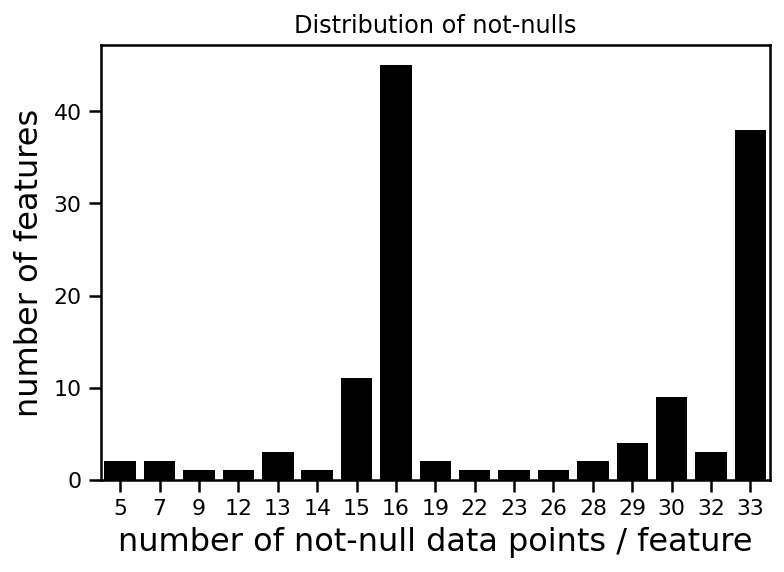

In [8]:
sns.countplot(classifi_df[classifi_df.columns.difference(['tumor_type','patient'])].notnull().sum(),
              color='k')

plt.title('Distribution of not-nulls')
plt.ylabel('number of features',size=16)
plt.xlabel('number of not-null data points / feature',size=16);

In [9]:
nonnull_max = classifi_df[classifi_df.columns.difference(['tumor_type','patient'])].notnull().sum().max()
nonnull_max

33

## loop over min_data threshold

In [35]:
my_range = range(5,nonnull_max + 1)
data_points_counts = []
features_counts = []

for min_data in my_range:
    
    temp_df  = classifi_df.loc[:,classifi_df.notnull().sum()>=min_data]
    
    data_points_counts.append(temp_df.dropna().shape[0])
    
    # we subtruct 2 because of the 'patients' and 'tumor_type' (that are not X and they have 0 NaN)      
    features_counts.append(temp_df.dropna().shape[1] - 2)

plot df size as function of threshold

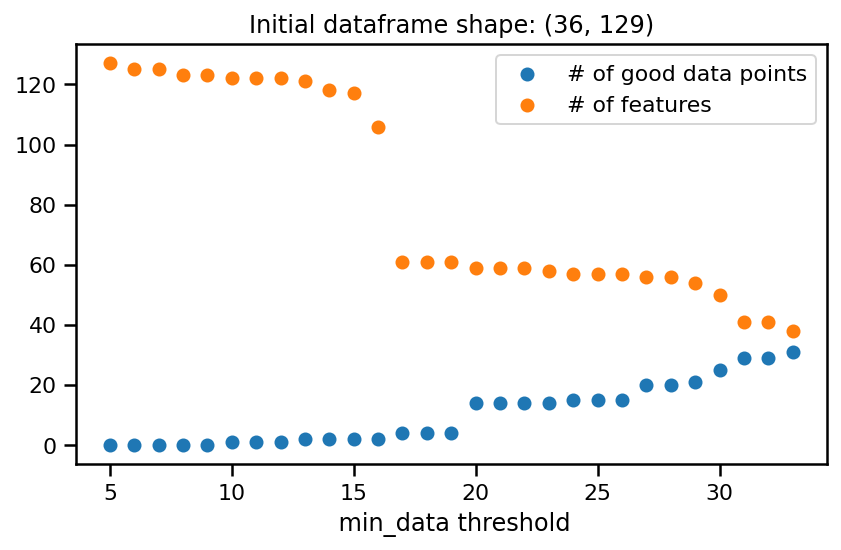

In [36]:
plt.scatter(my_range,data_points_counts,label='# of good data points')
plt.scatter(my_range,features_counts,label='# of features')


plt.title('Initial dataframe shape: {}'.format(classifi_df.shape))
plt.xlabel(' min_data threshold')
plt.legend();

plt.tight_layout()
plt.savefig('./plots_classification/data_size_after_threshold.pdf')

## selecting features with least __33__ data points

In [37]:
trial_df = classifi_df.loc[:, classifi_df.notnull().sum() >= nonnull_max]
print(trial_df.shape)
trial_df.tumor_type.value_counts()

(36, 40)


resistant    21
sensitive    15
Name: tumor_type, dtype: int64

In [38]:
# after droppping nans:
print(trial_df.dropna().shape)
trial_df.dropna().tumor_type.value_counts()

(31, 40)


resistant    17
sensitive    14
Name: tumor_type, dtype: int64

here we applied to the previous dataframe:

In [39]:
classifi_df = trial_df.dropna()
classifi_df.shape

(31, 40)

# preprocessing 

In [10]:
from sklearn.preprocessing import scale

preparing X and Y

In [40]:
my_x = classifi_df.drop(['tumor_type', 'patient'],axis=1)
my_y = classifi_df['tumor_type']

print(my_x.shape)
my_y.shape

(31, 38)


(31,)

output names of features used for the classification:

In [41]:
my_x.columns

Index(['IFNG LYS CBA', 'IFN Lys normalized to conc', 'IL8 ser', 'IP10 ser',
       'Eotaxin ser', 'TARC ser', 'MCP1 ser', 'RANTES ser', 'MIP1a ser',
       'MIG ser', 'ENA78 ser', 'MIP3a ser', 'GROa ser', 'ITAC ser',
       'MIP1b ser', 'IL8 lys', 'NO IL8', 'IP10 lys', 'NO IP10', 'Eotaxin lys',
       'NO eotax', 'TARC lys', 'NO tarc', 'MCP1 lys', 'NO mcp1', 'RANTES lys',
       'NO rantes', 'MIP1a lys', 'MIG lys', 'NO mig', 'ENA78 lys', 'MIP3a lys',
       'GROa lys', 'NO gora', 'ITAC lys', 'NO itac', 'MIP1b lys', 'NO mip1b'],
      dtype='object')

here we __standardize the features__

In [42]:
scale(my_x,copy=False);

# training the model
( as usual, choose the most model for your case from the 
[sklearn guide](http://scikit-learn.org/stable/tutorial/machine_learning_map/))

we start with random forest (as it was already tested) - maybe simpler models can be good too )

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [46]:
rfc = RandomForestClassifier()
rfc.fit(my_x,my_y)

RandomForestClassifier()

estimate test-error with cross validation
(given that the class sizes are almost the same (13 VS 12), accuracy could be a good metric -    
find other metrics
[in this list](http://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics))

In [47]:
# cv=None, to use the ---> default 3-fold cross validation <---
cross_val_score(rfc, my_x, my_y, scoring='accuracy',cv=5)

array([0.57142857, 0.5       , 0.66666667, 0.5       , 0.83333333])

# optimizing hyper parameters

prepare set of values for the hyper parameters:

In [48]:
n_trees = list(range(10,200,20))
tree_depth = list(range(10,110,20))
param_grid = dict(n_estimators=n_trees, max_depth=tree_depth)

print('therefore the grid will have',len(tree_depth), 'x', len(n_trees),'points')

therefore the grid will have 5 x 10 points


_fit the model_ on `grid` of hyper parameters

mind that these results are __not rebust...__ - the `best_params_` change quite often, from run to run...

In [86]:
grid = GridSearchCV(rfc, param_grid, scoring='accuracy',cv=5, n_jobs=7)
%time grid.fit(my_x, my_y)

print('best_params:',grid.best_params_)
print('best_score:',grid.best_score_)

CPU times: user 430 ms, sys: 26.8 ms, total: 457 ms
Wall time: 9.73 s
best_params: {'max_depth': 50, 'n_estimators': 10}
best_score: 0.7428571428571429


preparing data to plot test scores:

In [87]:
x_scores = grid.cv_results_['param_max_depth'].data
y_scores = grid.cv_results_['param_n_estimators'].data
z_scores = grid.cv_results_['mean_test_score']

you can choose the palette as usual from 
[this list](http://matplotlib.org/users/colormaps.html)

In [54]:
import matplotlib.cm as cm

plot test scores

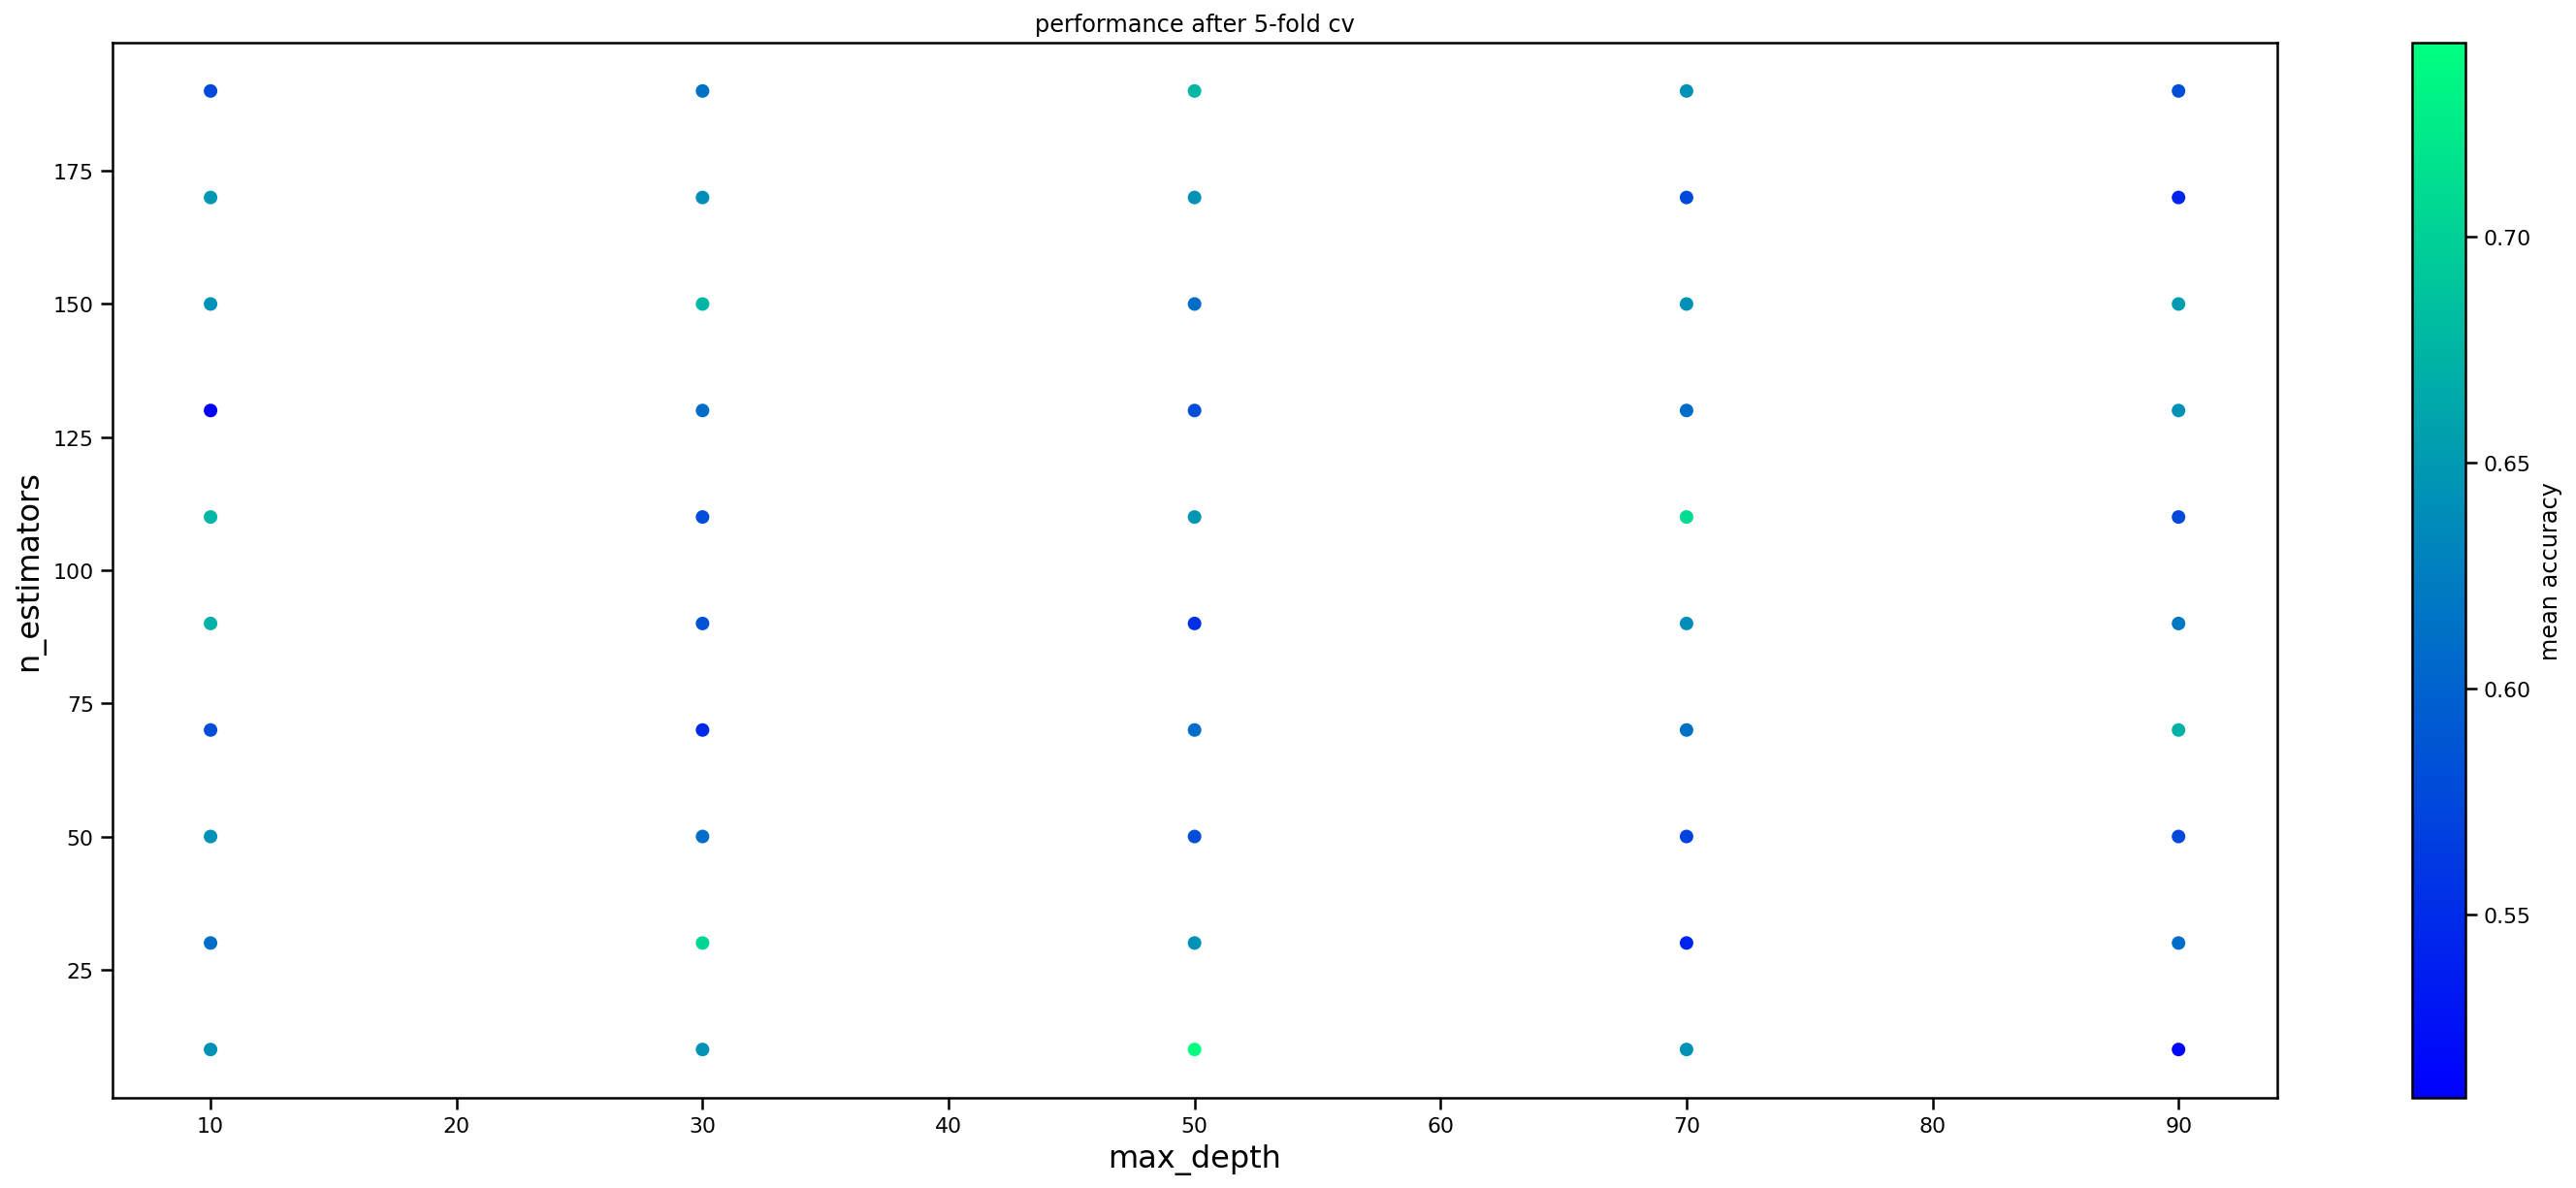

In [88]:
plt.rcParams = inline_rc

plt.scatter(x_scores,y_scores,c=z_scores,cmap=cm.winter)

plt.title('performance after {}-fold cv'.format(grid.cv) )
plt.colorbar(label='mean ' + grid.scoring)
plt.xlabel('max_depth',size=16)
plt.ylabel('n_estimators',size=16);

# inspect features importance

we first train again the model with the best hyper-parameters got after GridSearchCV:

In [89]:
best_forest = grid.best_estimator_
best_forest.fit(my_x,my_y)

RandomForestClassifier(max_depth=50, n_estimators=10)

compute _mean_ importances and get the _sorted indices_ for the plot

(for a __definition of the importance__, please refer to the reference pointed in 
[this post](http://stackoverflow.com/questions/15810339/how-are-feature-importances-in-randomforestclassifier-determined))

In [90]:
importances = best_forest.feature_importances_
sorted_ind = np.argsort(importances)[::-1]

plotting `feature_importances_`

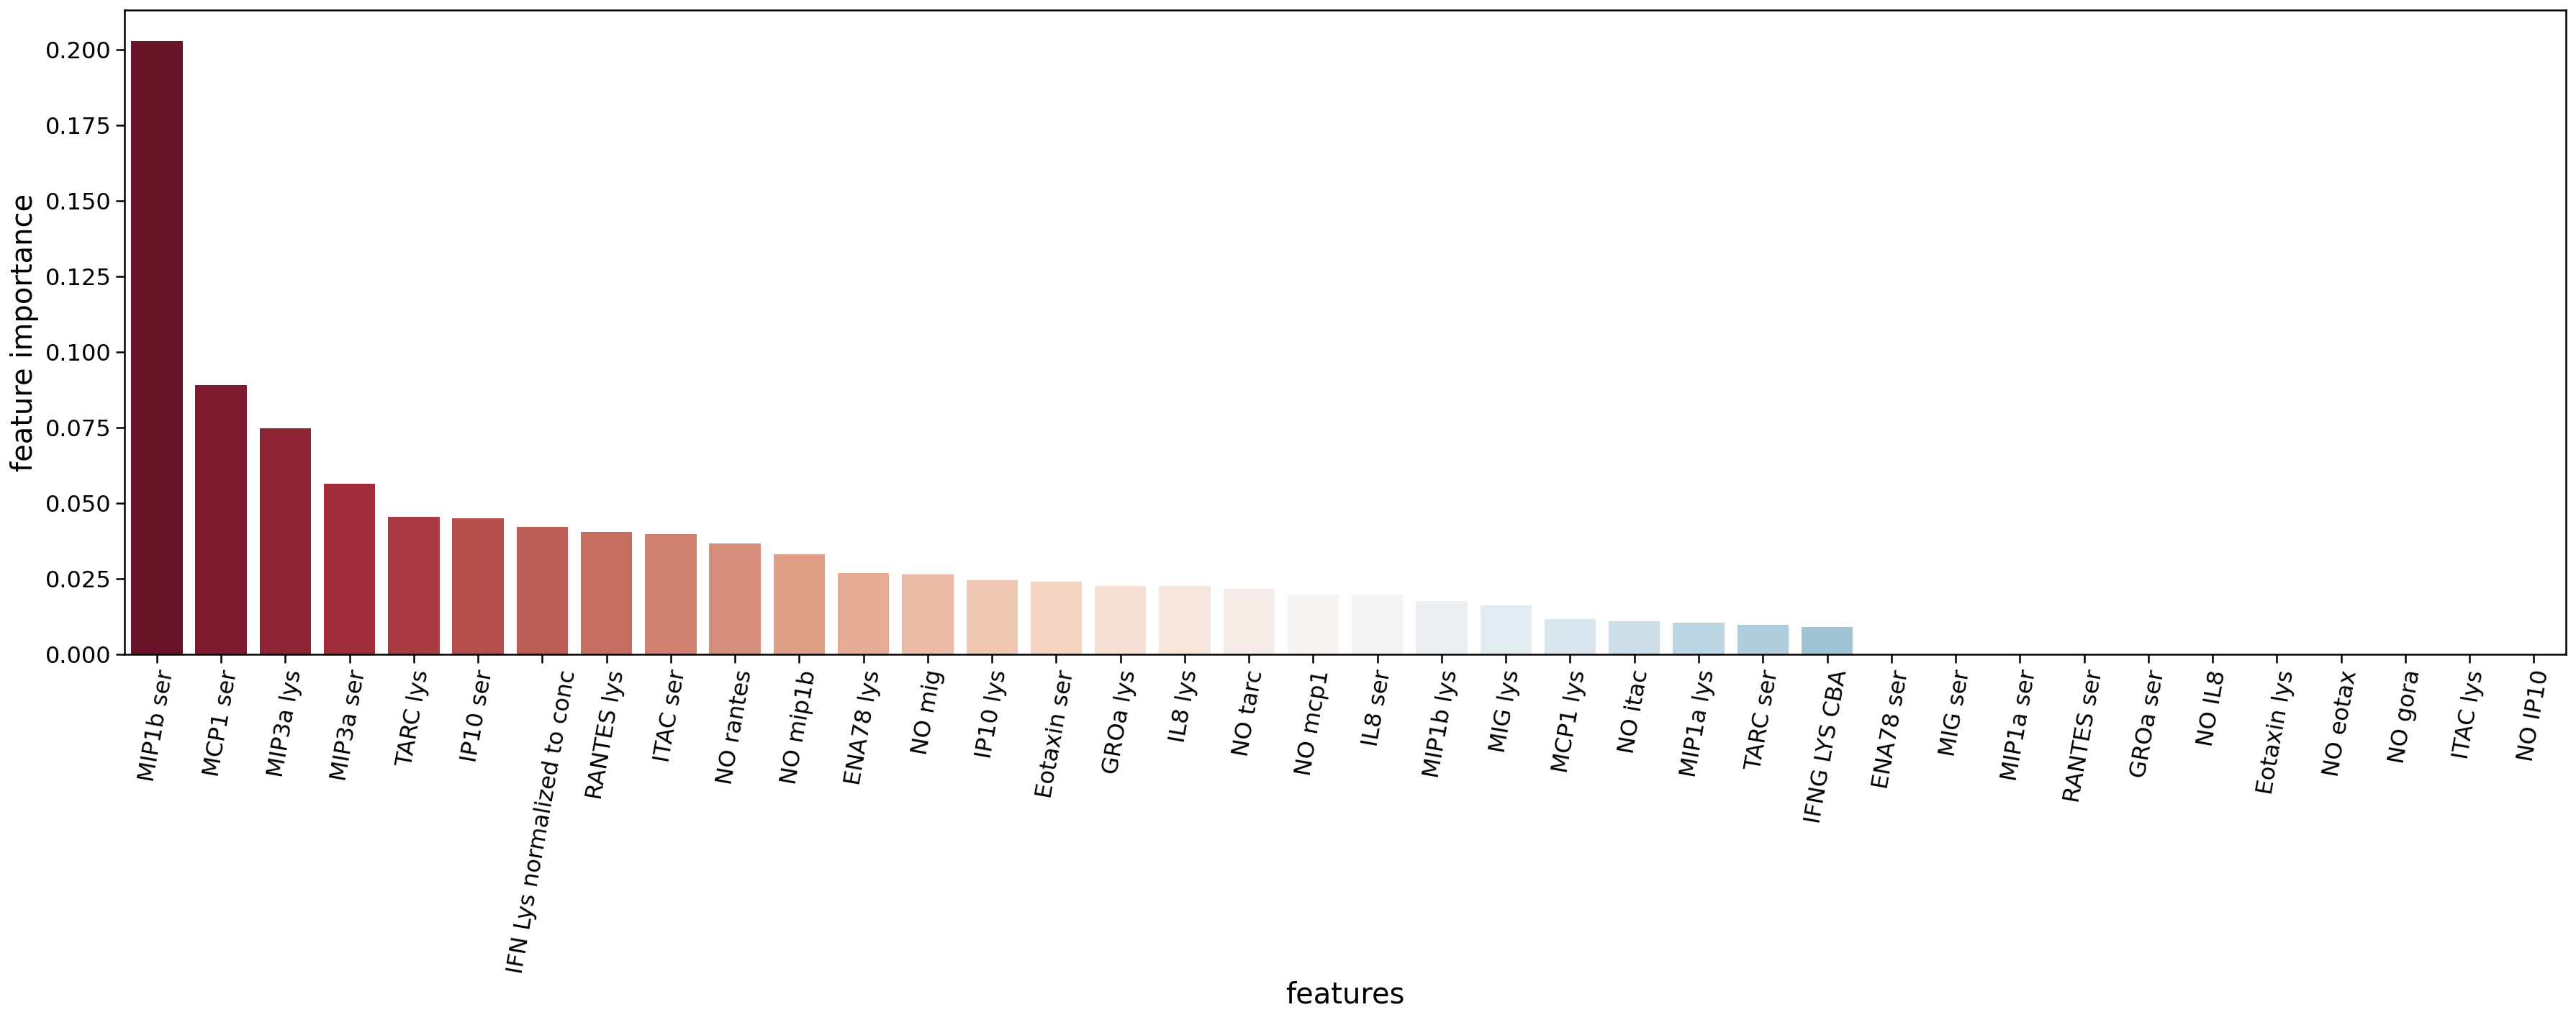

In [91]:
plt.rcParams["figure.figsize"] = [25,10]

sns.barplot(x=my_x.columns[sorted_ind],y=importances[sorted_ind],palette="RdBu")

plt.xticks(rotation=80,size=16)
plt.yticks(size=16)
plt.ylabel('feature importance',size=20)
plt.xlabel('features',size=20)

plt.tight_layout()
plt.savefig('./plots_classification/feat_import_random_forest_38_feats.pdf');

# learning curves


Plotting Learning Curves

On the left side the learning curve of a naive Bayes classifier is shown for
the digits dataset. Note that the training score and the cross-validation score
are both not very good at the end. However, the shape of the curve can be found
in more complex datasets very often: the training score is very high at the
beginning and decreases and the cross-validation score is very low at the
beginning and increases. On the right side we see the learning curve of an SVM
with RBF kernel. We can see clearly that the training score is still around
the maximum and the validation score could be increased with more training
samples.



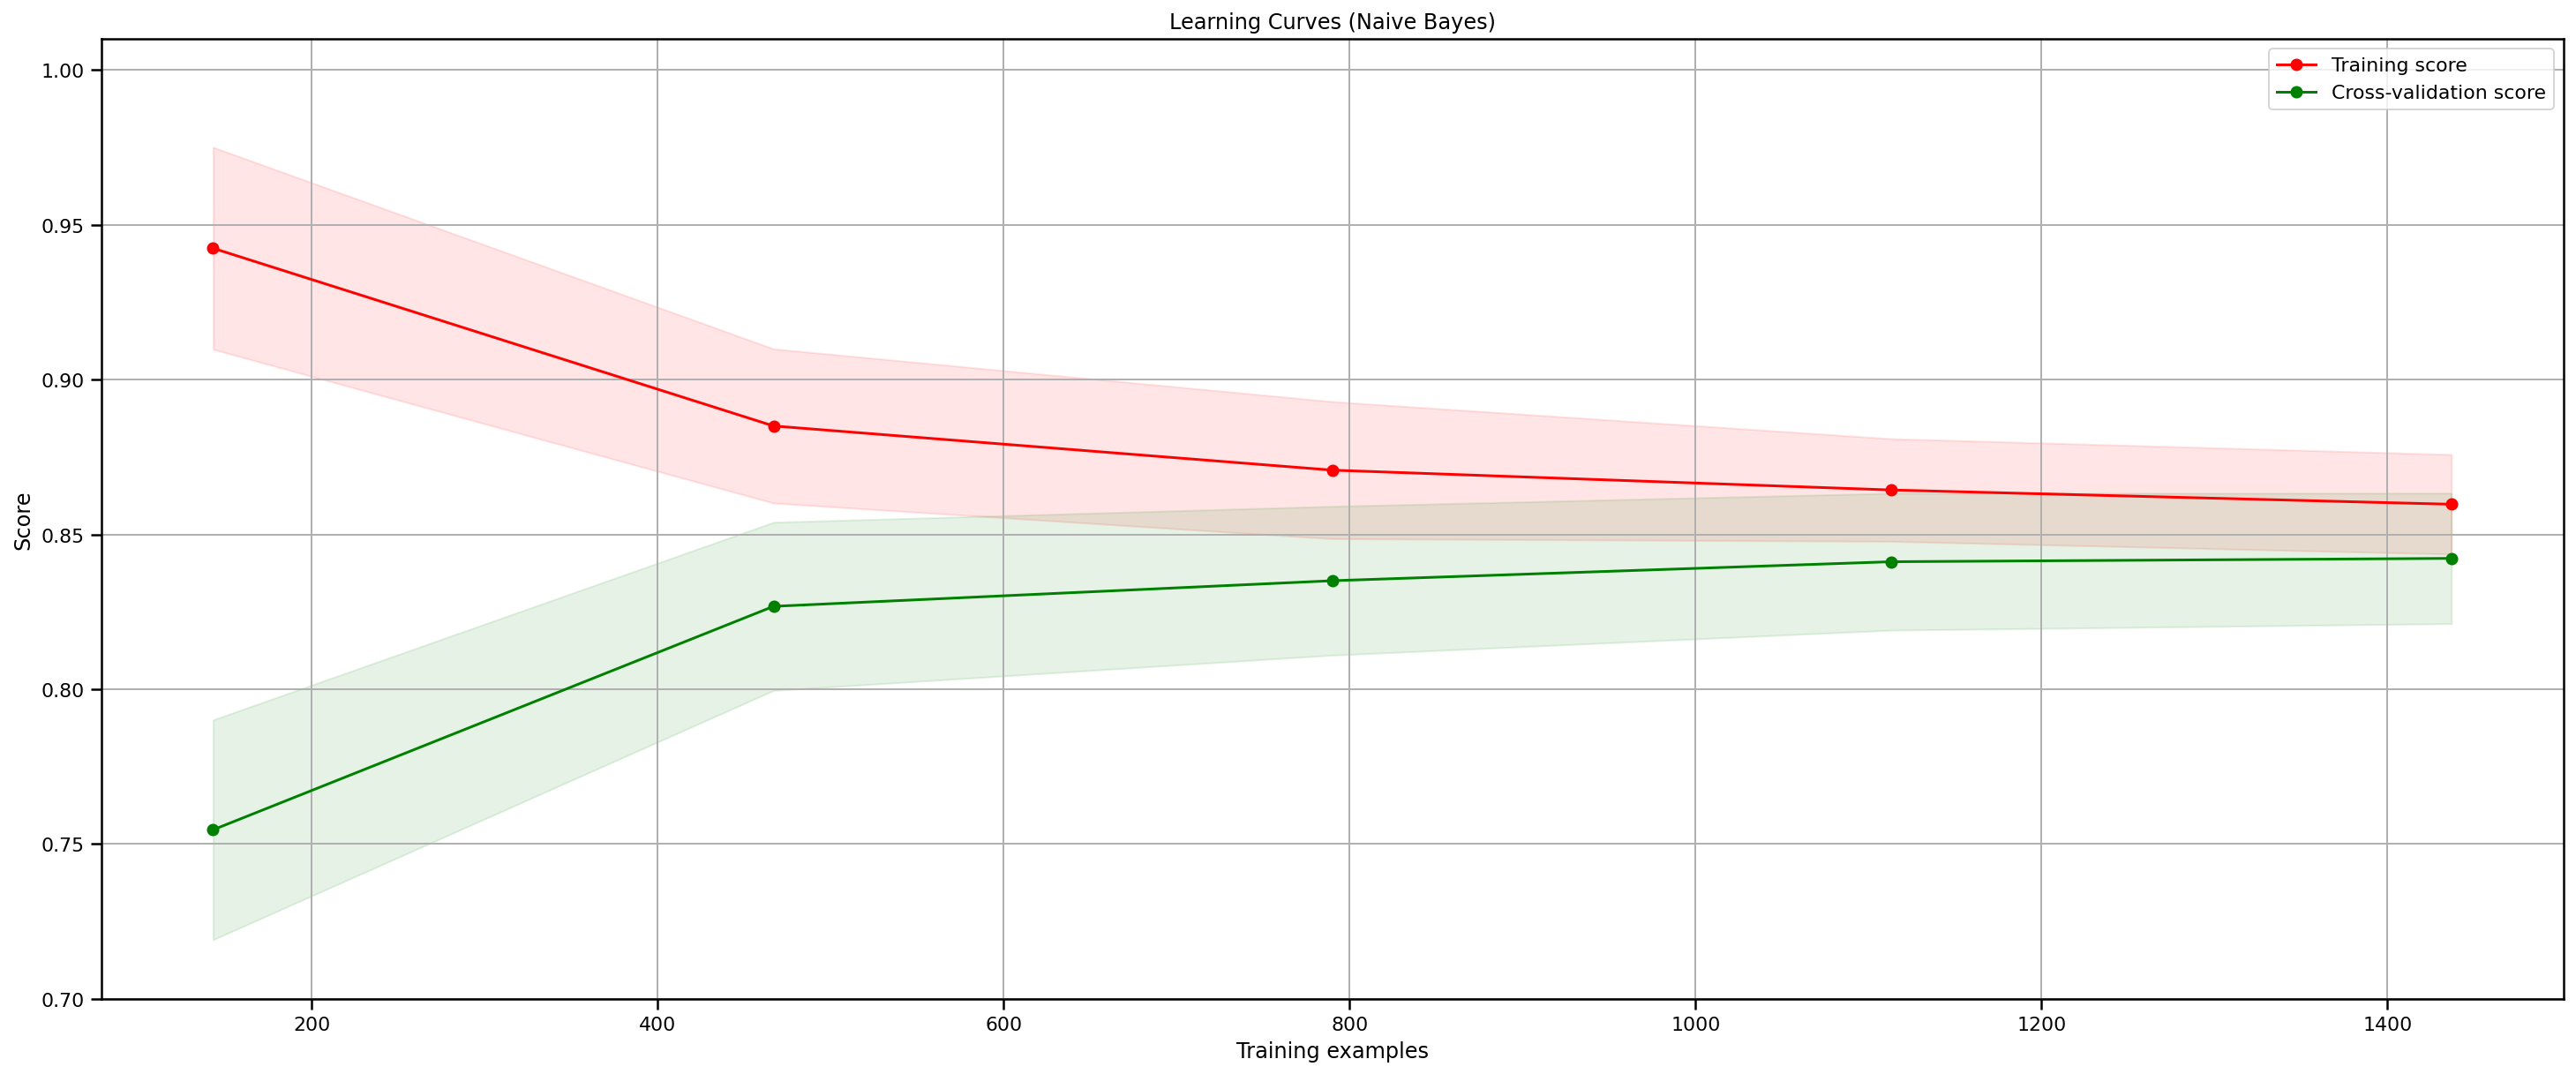

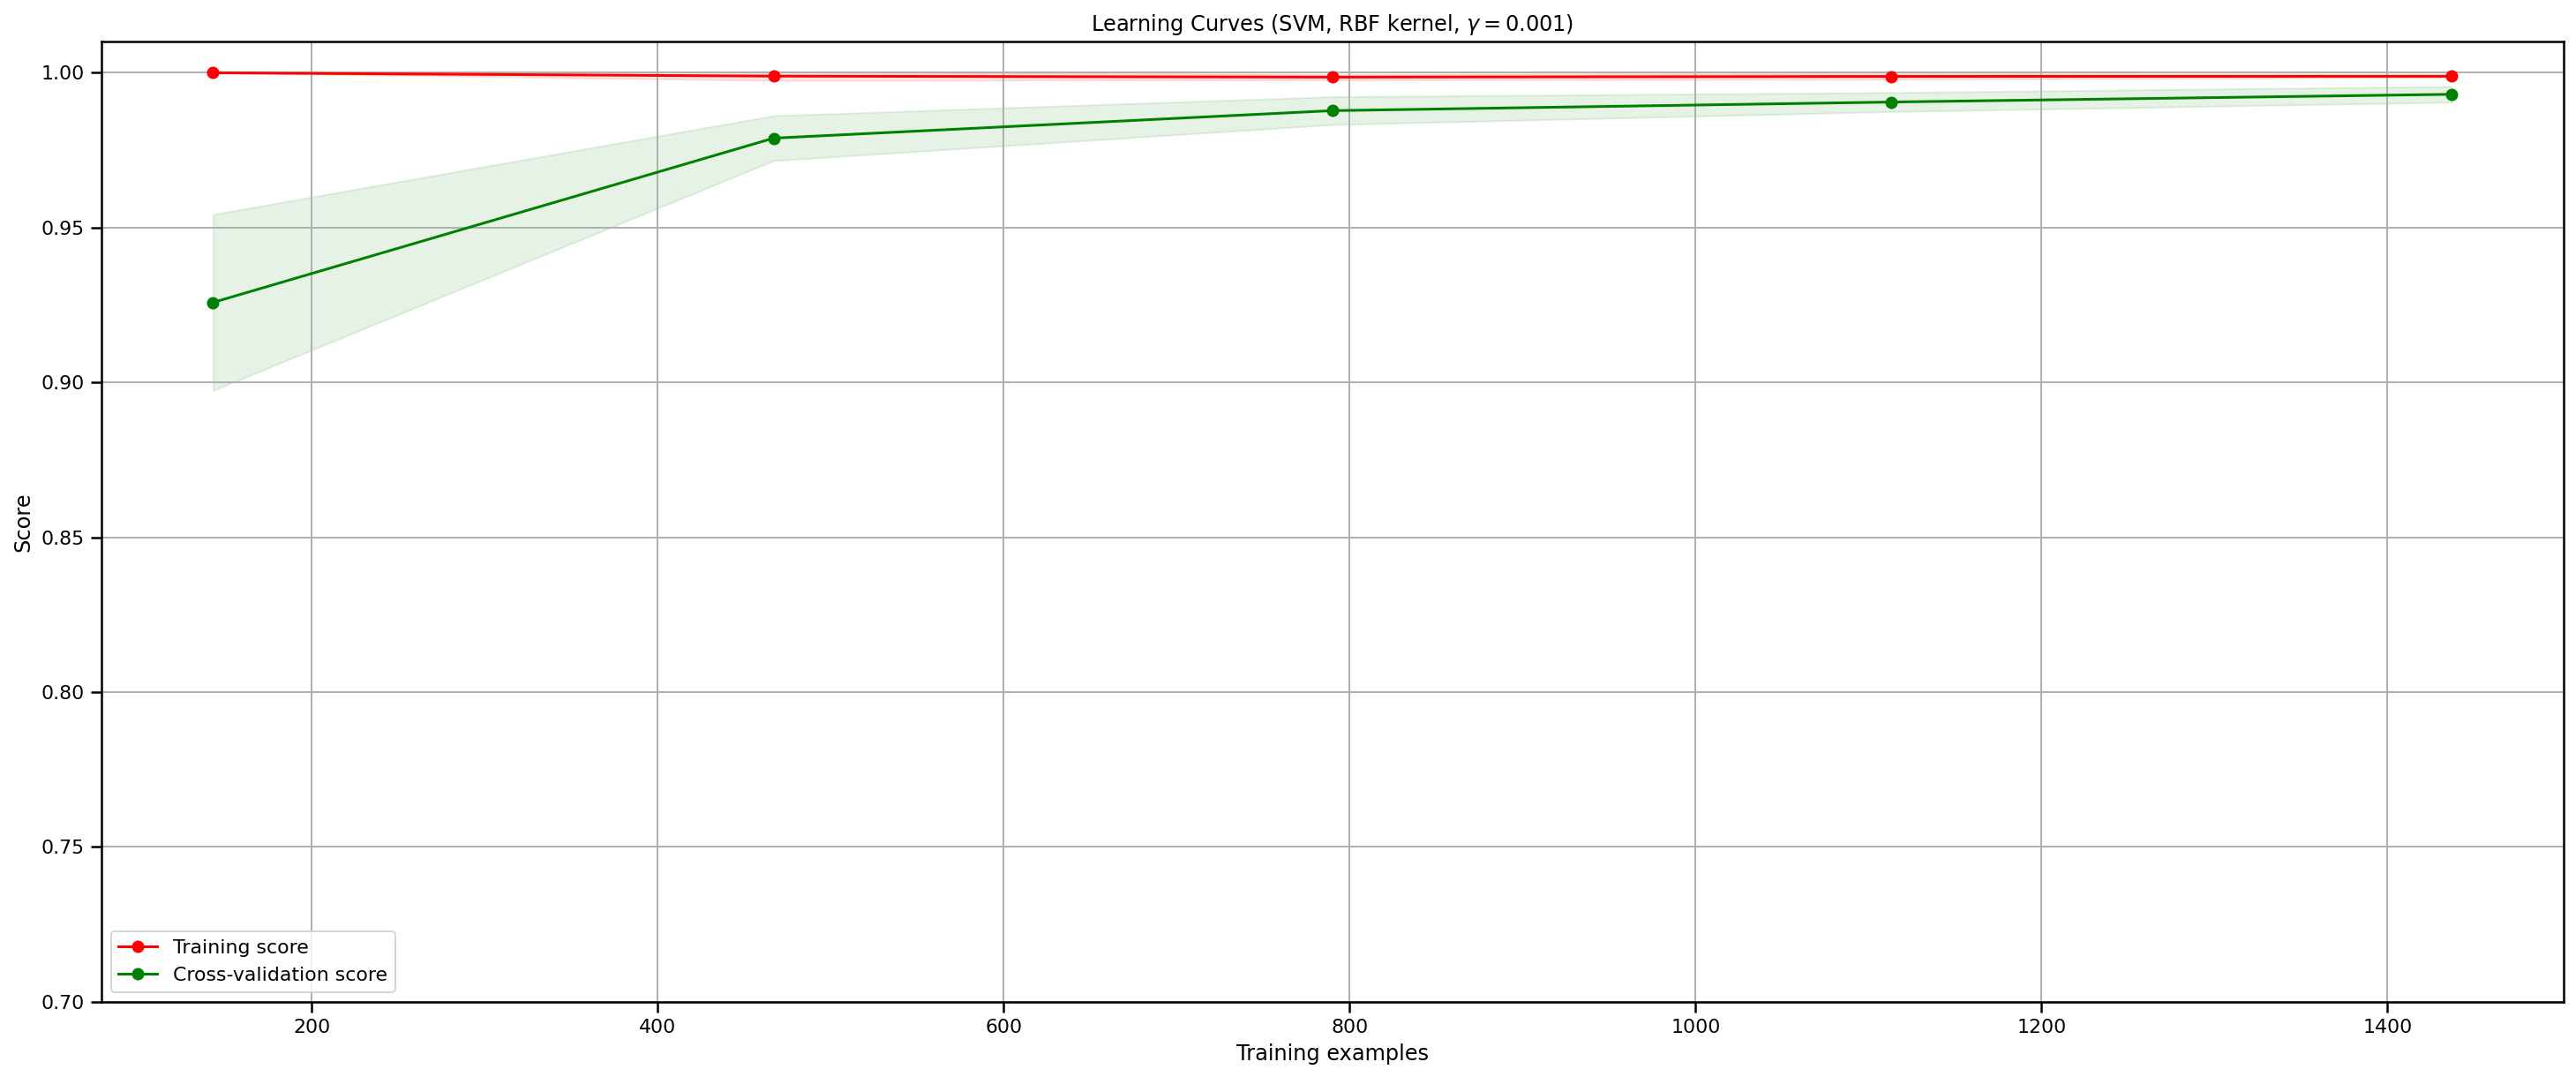

In [94]:
from sklearn.model_selection import learning_curve
from plot_learning_curve import plot_learning_curve

In [96]:
my_title = "Learning curves (RFC, n_estimators={}, max_depth={})".format(best_forest.n_estimators,
                                                                         best_forest.max_depth)

learning curve on _all features_

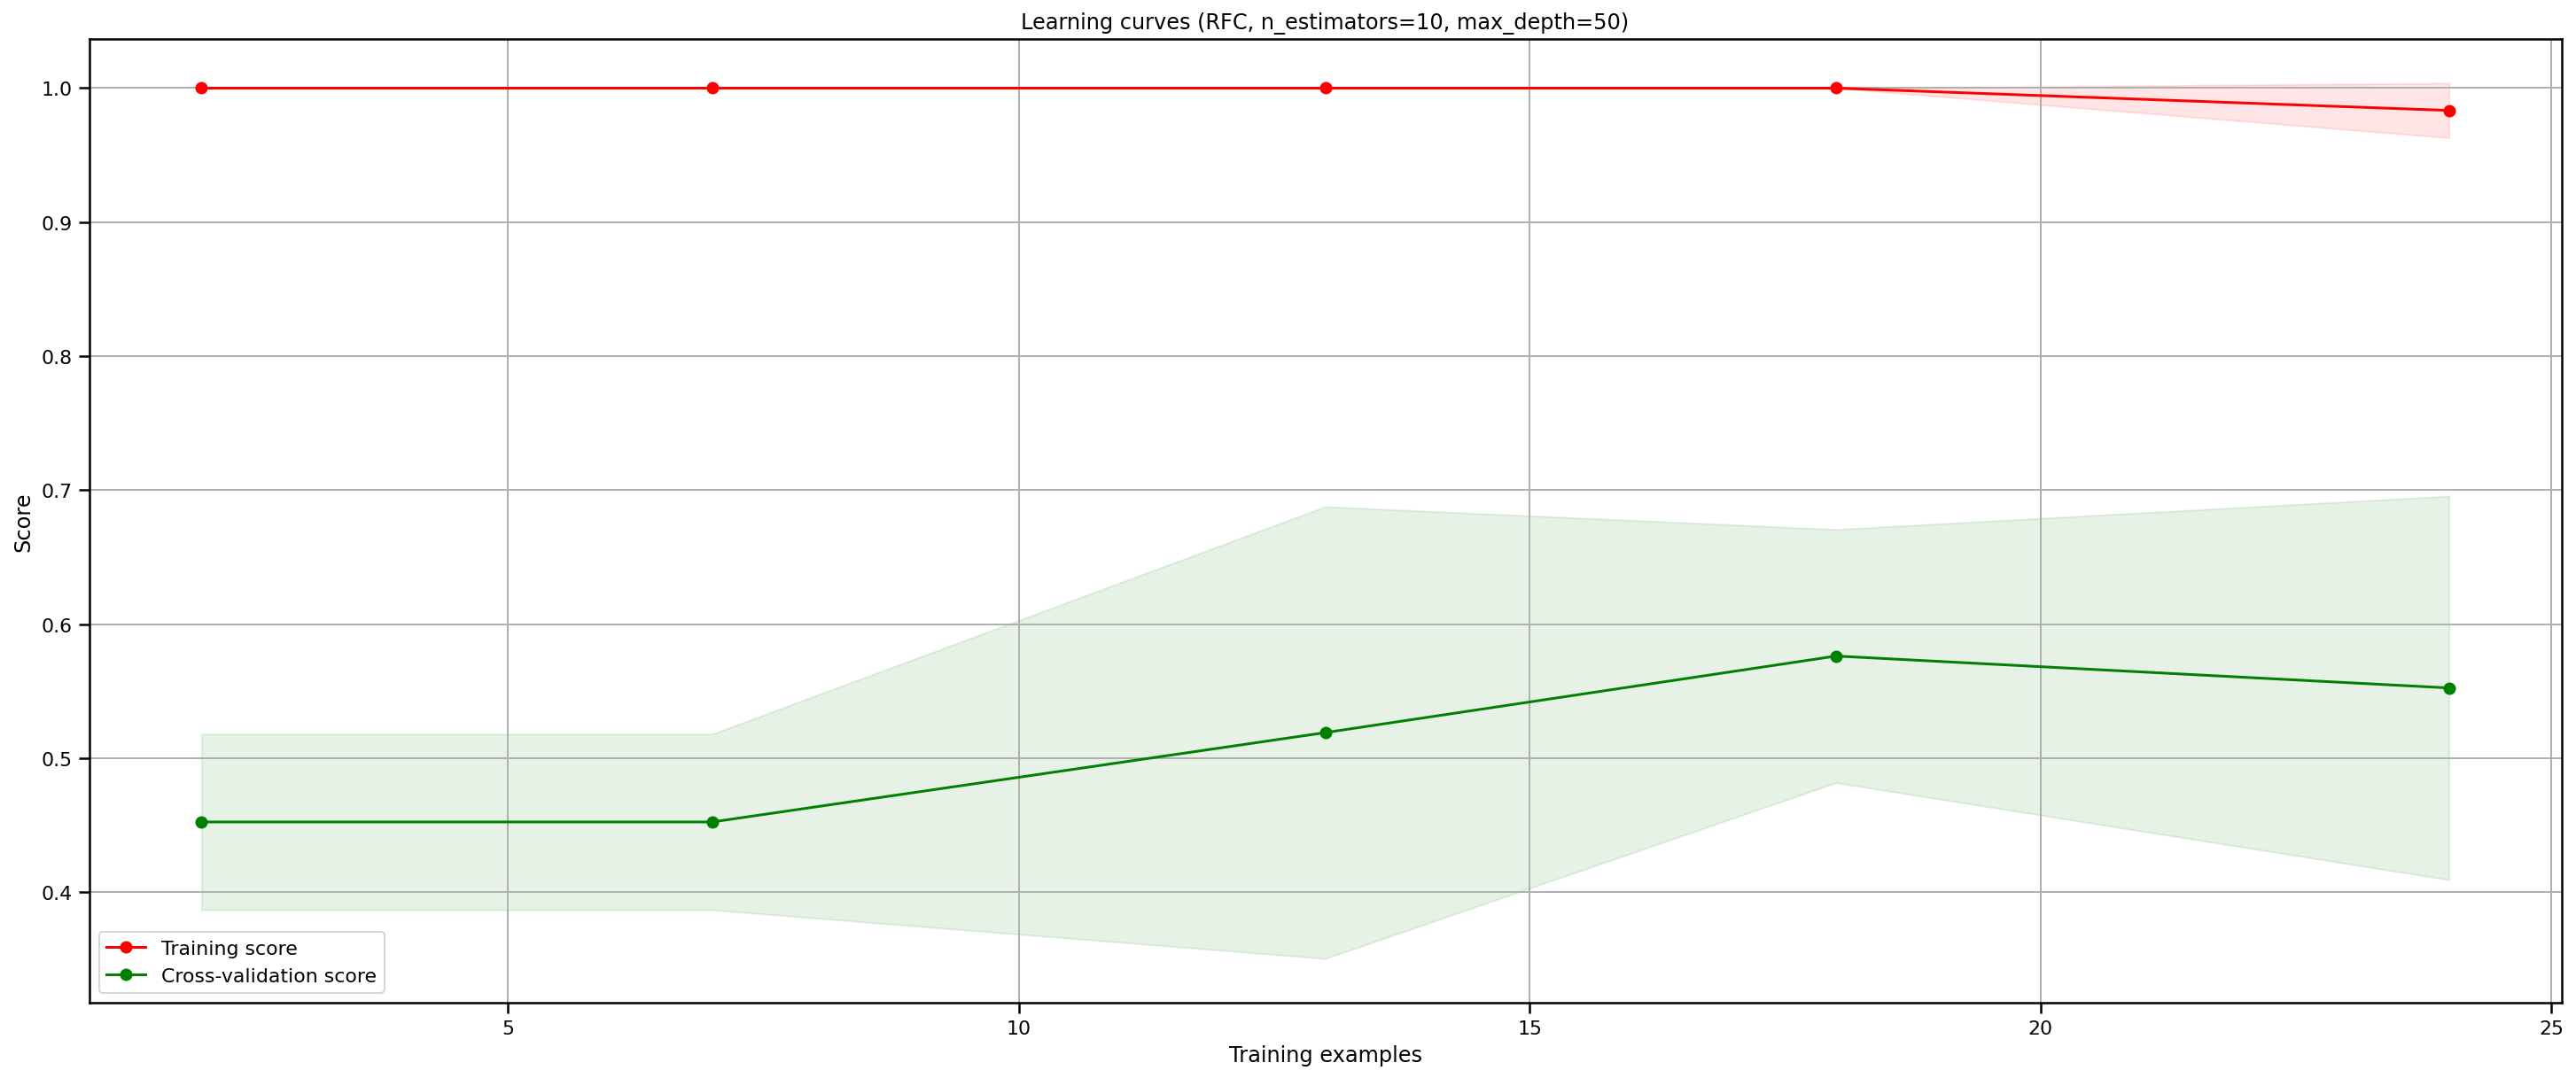

In [98]:
plot_learning_curve(estimator=best_forest,cv=5,X=my_x,y=my_y,title=my_title);